In [1]:
import torch
import torch.nn as nn
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import pandas as pd
import uproot
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
path = '/ceph/lsowa/recoil/dt.root'
dfdata = None
for file in uproot.iterate(path+":ntuple", library="pd"):
    if dfdata is None:
        dfdata = pd.DataFrame.from_dict(file)
    else:
        df = pd.DataFrame.from_dict(file)
        dfdata = pd.concat([dfdata, df])

/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [3]:
path = '/ceph/lsowa/recoil/mc.root'
dfmc = None
for file in uproot.iterate(path+":ntuple", library="pd"):
    if dfmc is None:
        dfmc = pd.DataFrame.from_dict(file)
    else:
        df = pd.DataFrame.from_dict(file)
        dfmc = pd.concat([dfmc, df])

/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [4]:
print('MC shape ', dfmc.shape)
print('Data shape ', dfdata.shape)

MC shape  (2189044, 213)
Data shape  (1796149, 172)


In [5]:
dfmc['genbosonmass']

0          93.659927
1          87.046265
2          86.994781
3          88.692917
4          91.335983
             ...    
2189039    91.346970
2189040    92.301422
2189041    92.065903
2189042    90.817581
2189043    89.039566
Name: genbosonmass, Length: 2189044, dtype: float32

In [6]:
cond = ['pt_vis_c_x',
'pt_vis_c_y',
'pt_vis_c',
'phi_vis_c',
'uP1_uncorrected',
'uP2_uncorrected',
'beta_1',
'beta_2',
'bphi_1',
'bphi_2',
'bpt_1',
'bpt_2',
'btag_value_1',
'btag_value_2',
'dxyErr_1',
'dxyErr_2',
'dxy_1',
'dxy_2',
'dxybs_1',
'dxybs_2',
'dzErr_1',
'dzErr_2',
'dz_1',
'dz_2',
'eta_1',
'eta_2',
'highPtId_1',
'highPtId_2',
'highPurity_1',
'highPurity_2',
'jeta_1',
'jeta_2',
'jphi_1',
'jphi_2',
'jpt_1',
'jpt_2',
'jtag_value_1',
'jtag_value_2',
'looseId_1',
'looseId_2',
'mass_1',
'mass_2',
'metSumEt',
'metcov00',
'metcov01',
'metcov10',
'metcov11',
'metphi',
'mjj',
'phi_1',
'phi_2',
'ptErr_1',
'ptErr_2',
'pt_1',
'pt_2']
names = ['uP1_uncorrected', 'uP2_uncorrected']

for key in data.keys():
    if key in mc.keys():
        print(key)

In [7]:
n = 200000

cdata = torch.tensor(dfdata[cond].to_numpy().astype(float))[:200000,:]
cmc = torch.tensor(dfmc[cond].to_numpy().astype(float))[:100000,:]

data = torch.tensor(dfdata[names].to_numpy().astype(float))[:200000,:]
mc = torch.tensor(dfmc[names].to_numpy().astype(float))[:100000,:]

In [8]:
lr = 0.001
device = torch.device('cuda:3')

In [9]:
def mlp_constructor(input_dim=2, out_dim=2, hidden_nodes=200):
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, out_dim)
        )
    return model

In [10]:
model = Ff.SequenceINN(2)
for k in range(8):
    model.append(Fm.RNVPCouplingBlock, subnet_constructor=mlp_constructor, clamp=2)
    #model.append(Fm.PermuteRandom)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=3)

In [12]:
dataset = TensorDataset(data, cdata)
loader = DataLoader(dataset, shuffle=True, batch_size=5000)

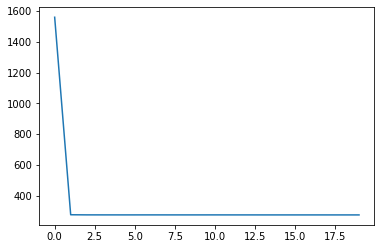

In [13]:
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
model.to(device)

losses = []
for epoch in range(20):
    epo_loss = 0
    for d, c in loader:
        d = d.to(device)
        c = c.to(device)
        
        z, log_jac = model(d.float(), c=c)
        
        zz = torch.sum(z**2, dim=-1)
        neg_log_likeli = 0.5 * zz - log_jac
        loss = torch.mean(neg_log_likeli)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epo_loss += loss.cpu().detach().numpy()
    scheduler.step(epo_loss)
    losses.append(epo_loss)
    print('Epoch {:.0f} Loss: {:.2f}'.format(epoch, loss), end="\r")

plt.plot(losses)

In [14]:
model.cpu()
z, jac = model(data.float(), cdata)

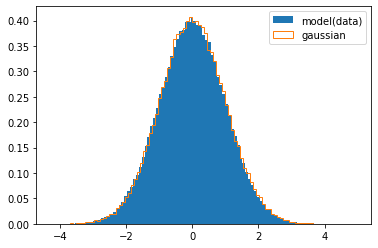

In [15]:
plt.clf()
gaussian = pz.sample((100000, ))
_ = plt.hist(z[:,0].cpu().detach().numpy(), bins=100, density=True, label='model(data)')
_ = plt.hist(gaussian[:,0].cpu().detach().numpy(), bins=100, density=True, histtype=u'step', label='gaussian')
plt.legend()

In [16]:
z = gaussian #pz.sample((100000, ))
#z = z.to(device)
u, log_jac = model(z, rev=True, c=cmc)
u = u.cpu().detach().numpy()

### Compare MC -> Data

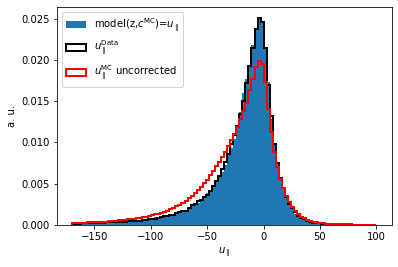

In [17]:
plt.clf()
interval = [-170, 100]
_ = plt.hist(u[:,0], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\parallel$')
_ = plt.hist(data[:,0].cpu().detach().numpy(), histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='black', label=r'$u^\mathrm{Data}_\parallel$')
_ = plt.hist(dfmc['uP1_uncorrected'].values, histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\parallel$ uncorrected')
plt.xlabel(r'$u_\parallel$')
plt.ylabel('a. u.')
plt.legend()

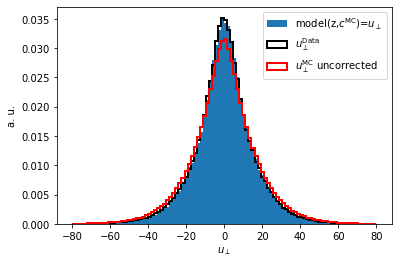

In [18]:
plt.clf()
interval = [-80, 80]
_ = plt.hist(u[:,1], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\perp $')
_ = plt.hist(data[:,1].cpu().detach().numpy(), histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='black', label=r'$u^\mathrm{Data}_\perp $')
_ = plt.hist(dfmc['uP2_uncorrected'].values, histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\perp $ uncorrected')
plt.xlabel(r'$u_\perp$')
plt.ylabel('a. u.')
plt.legend()

In [19]:
for key in dfdata.keys():
    if 'pt' in key:
        print(key)

pt_vis_c_x
pt_vis_c_y
pt_vis_c
bpt_1
bpt_2
genbosonpt
jpt_1
jpt_2
mediumPromptId_1
mediumPromptId_2
ptErr_1
ptErr_2
pt_1
pt_2
pt_rc_1
pt_rc_2
pt_vis


In [20]:
ptz = dfmc['pt_vis_c'][:100000]
up = u[:,0]

In [21]:
keep = np.logical_and(200 > ptz, ptz > 25)
ptz = ptz[keep]
up = up[keep]
r = -up/ptz

In [22]:
xmin = 25
xmax = 200
bins = [25, 50, 75, 100, 125, 150, 175, 200]
hist_raw, edges = np.histogram(ptz, bins = bins, range=[xmin, xmax])
hist_weighted, edges = np.histogram(ptz, bins = bins, weights=r, range=[xmin, xmax])

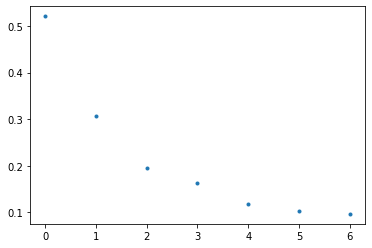

In [23]:
plt.plot(hist_weighted/hist_raw, '.')

(-200.0, 200.0)

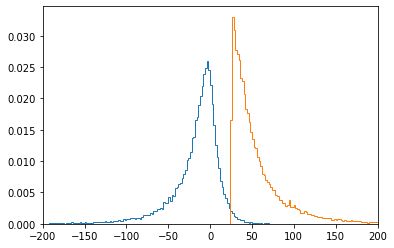

In [25]:
n, bins, edges = plt.hist(up, histtype=r'step', bins=200, range=[-200, 200], density=True)
n1, bins1, edges1 = plt.hist(ptz, histtype=r'step', bins=200, range=[-200, 200], density=True)
plt.xlim([-200, 200])